In [1]:
#pip install statsmodels

In [2]:
#pip install pmdarima


In [61]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [115]:
import pandas as pd
pd.options.mode.chained_assignment = None #remove warning masseges from panda
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #stationary test
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA #this package doesn't work anymore and was switched to the one underneth
from statsmodels.tsa.arima.model import ARIMA 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from pmdarima.arima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
import statsmodels.stats.descriptivestats as statdesc
from statsmodels.stats.diagnostic import acorr_ljungbox

In [6]:
POS = pd.read_csv('C:/Users/althy/Desktop/Graduation_Project/Final_Graduation_Project-main/POS_monthly_2023.csv',index_col='Date', parse_dates=True)

In [7]:
POS = pd.DataFrame(POS)

<h4> Exploring and cleaning Data

In [8]:
POS.head(5)

,Total
Date,
Jan-15,32156481.0
Feb-15,29603197.0
Mar-15,32793427.0
Apr-15,30356911.0
May-15,33099974.0


In [9]:
POS.describe()

,Total
count,9.700000e+01
mean,2.088249e+08
std,2.062546e+08
min,2.960320e+07
25%,5.215320e+07
50%,1.063572e+08
75%,3.465955e+08
max,6.919239e+08


In [10]:
#checking for Nan values
POS.isna().values.any()

True

In [11]:
POS[POS.index.isna()]

,Total
Date,


seeing the NaN rows we can conclude that they are a mistake, so we can remove them

In [12]:
clean_POS = POS.dropna()

In [13]:
#checking for duplicated in date column.
clean_POS.index.duplicated().any()

False

C:\Users\althy\AppData\Local\Temp\ipykernel_24068\82820063.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sns.lineplot(x="Date", y="Total",


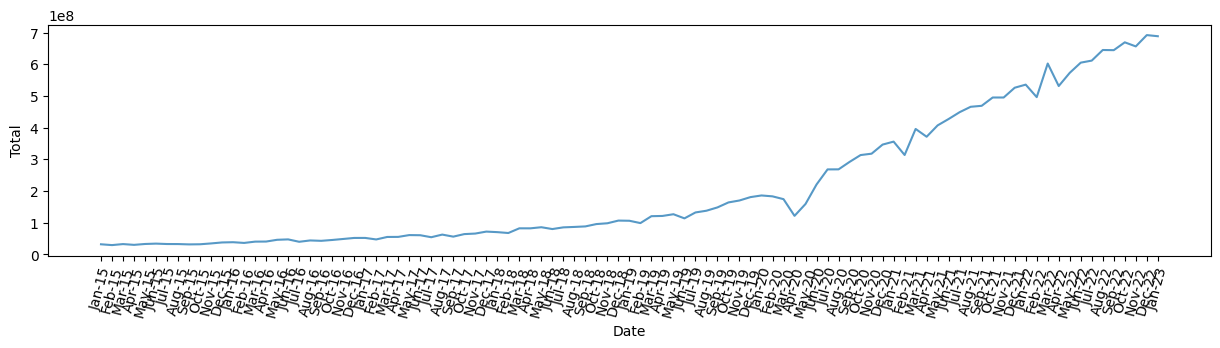

In [14]:
#making line plot 
plt.xticks(rotation=75)
fig = plt.gcf()
fig.set_size_inches(15, 3)
scatter = sns.lineplot(x="Date", y="Total", 
                          sizes=(40, 800), alpha=0.75, palette="BrBG", legend=False,
                          data=clean_POS)
plt.show()

<h3> Testing stationary

In [15]:
#function to test statonarity using Dickey-fuller test and ploting it 
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=6).mean()
    movingSTD = timeseries.rolling(window=6).std()
  
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    #Plot rolling statistics
    fig = plt.gcf()
    fig.set_size_inches(15, 3)
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.xticks(rotation=75)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Results of Dickey Fuller Test:
Test Statistic                 -0.420112
p-value                         0.906686
#Lags Used                     12.000000
Number of Observations Used    84.000000
Critical Value (1%)            -3.510712
Critical Value (5%)            -2.896616
Critical Value (10%)           -2.585482
dtype: float64


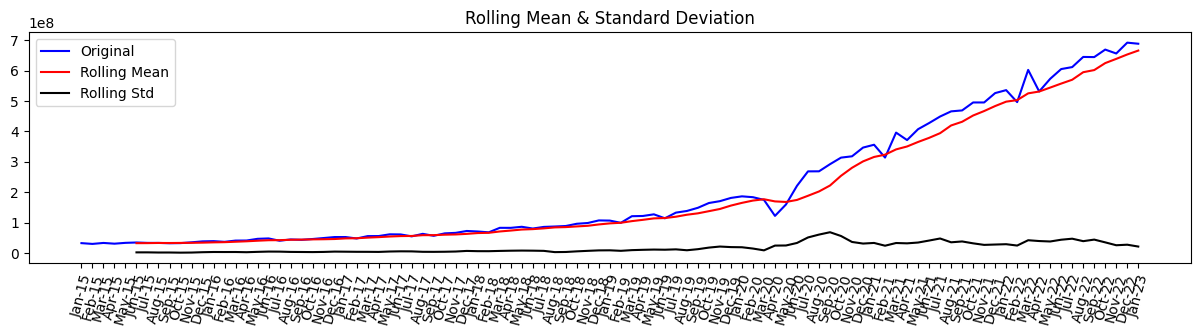

In [16]:
test_stationarity(clean_POS)

<h4> since p-value > 0.05 it's not stationary
so we will try transforming it with taking the first difference

Results of Dickey Fuller Test:
Test Statistic                 -1.188642
p-value                         0.678463
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


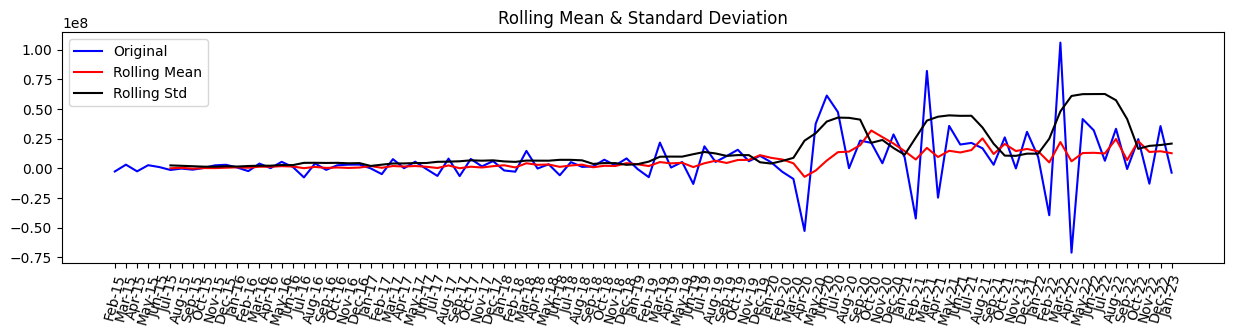

In [17]:
test_stationarity(clean_POS.diff().dropna())

<h5> p-value still high, so we will transform the data again by taking the log <h5>

Results of Dickey Fuller Test:
Test Statistic                 -5.104558
p-value                         0.000014
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


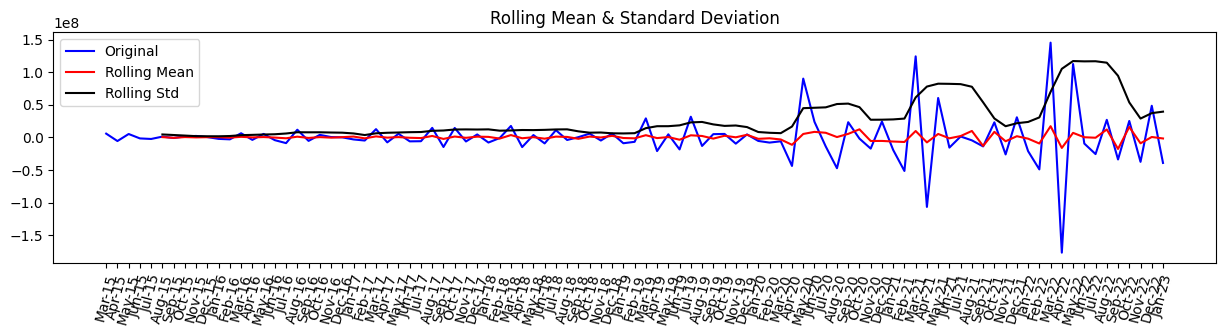

In [18]:
test_stationarity(clean_POS.diff().diff().dropna())

<h4> since the data got stationary after the seconed diffrence, then the d in ARIMA(p,d,q) is equal to 2

In [148]:
#function to analyze residual
def residual_analysis(residual):
    alpha = 0.05
 
    #testing H0: E(res)=0, if p-value < 0.05 then reject H0
    Eres = stats.ttest_1samp(residual, 0).pvalue
    print("checking if residuals are zero mean")
    print("h0: residuals are zero mean, h1: residuals are not zero mean")
    if Eres < alpha:
        print(f"since p-value {round(Eres,4)} < alpha = {alpha} we reject null hypothesis, residuals are not zero mean. \n")
    else:
        print(f"since p-value {round(Eres,4)} > alpha = {alpha} we accept null hypothesis, residuals are zero mean. \n")

    #testing the normality of the residuals, H0: residuals are normally distributed
    #using the Anderson-Darling test, if p-value < 0.05 then reject H0
    der_test = stats.anderson(residual).critical_values[2]
    print(f"Anderson-Darling test statistic for checking normality")
    print("h0: residuals are normally distributed, h1: residuals are not normally distributed")
    if der_test < alpha:
        print(f"since p-value {round(der_test,4)} < alpha = {alpha} we reject null hypothesis, residuals are not normally distributed. \n")
    else:
        print(f"since p-value {round(der_test,4)} > alpha = {alpha} we accept null hypothesis, residuals are normally distributed. \n")

    #checking for correlation between residuals
    result = acorr_ljungbox(residual)
    print("checking for correlation between residuals")
    print("h0: residuals are uncorrelated, h1: residuals are correlated")
    if any(result.lb_pvalue < alpha):
        print(f"since all p-value < alpha = {alpha} we reject null hypothesis, residuals are correlated. \n")
    else:
        print(f"since all p-value > alpha = {alpha} we accept null hypothesis, residuals are uncorrelated. \n")

    #If the residuals are randomly distributed around zero,
    #we would expect to see a roughly symmetric distribution centered around zero with no significant skewness or kurtosis.
    print("checking for ranomnies of residuals")
    print("if the are random then we would see a symmetric distribution centered around zero with no significant skewness or kurtosis")
    sns.set_style('whitegrid')
    plt.figure(figsize=(4, 3))
    sns.kdeplot(residual, fill=True)
    plt.axvline(x=0, color='k', linestyle='-')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.title('Density Plot of Residuals, for testing random distribution')
    plt.show()

In [20]:
#function to compare models using AIC and BIC scores
def assess_arima(model):
    AIC = model.aic
    BIC = model.bic
    KPI = {
        'AIC':AIC,
        'BIC':BIC,
        }   
    for key in KPI:
        print(key, '=', KPI[key])

In [23]:
#function that calculate mae, mape, mse and rmse between test data and predicted data
def KPI(test_data,y_pred):
    mae = mean_absolute_error(y_true=test_data, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=test_data, y_pred=y_pred)
    mse = mean_squared_error(y_true=test_data, y_pred=y_pred)
    rmse = np.sqrt(mse)
    #corr = np.corrcoef(y_pred.Total, test_data.Total)
    KPI = {
        'mape':mape,
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        #'corr':corr
    }   
    for key in KPI:
        print(key, '=', KPI[key])

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


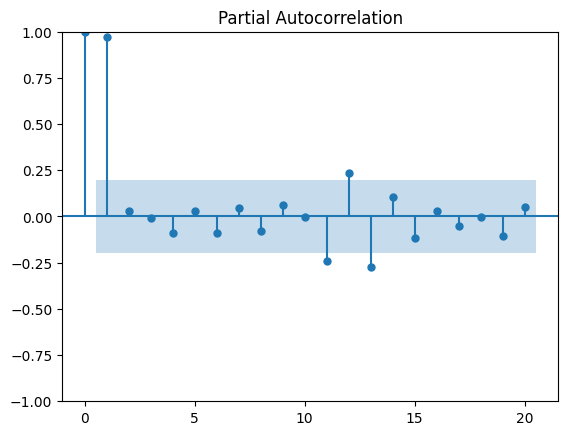

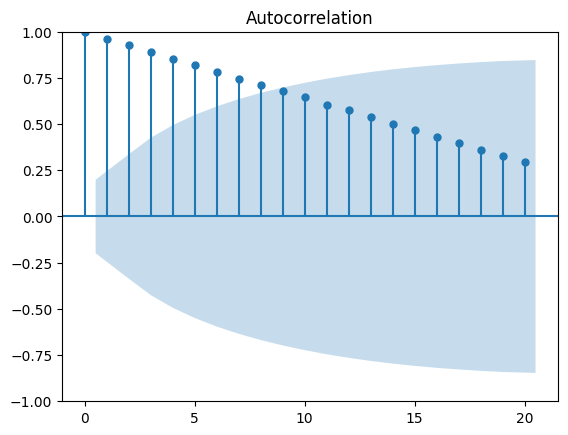

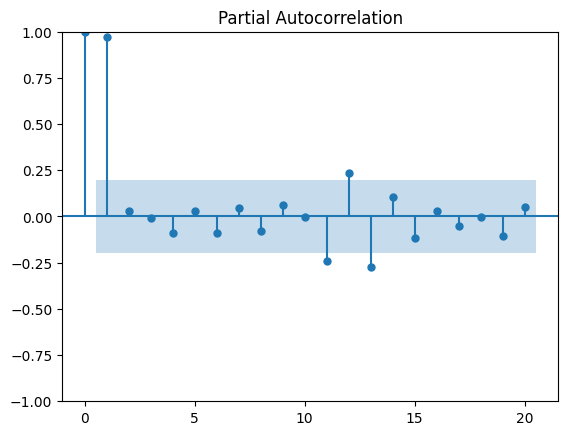

In [19]:
plot_acf(clean_POS)
plot_pacf(clean_POS)

<h3> since autocorrelation decay to zero, and partial autocorrelation cuts off after the 2nd itme lag, the model is ARIMA(0,2,2)

In [21]:
model = ARIMA(clean_POS, order=(0,2,2)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1735.947
Date:                Thu, 25 May 2023   AIC                           3477.893
Time:                        10:01:55   BIC                           3485.555
Sample:                             0   HQIC                          3480.989
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.4228      0.087    -16.387      0.000      -1.593      -1.253
ma.L2          0.4819      0.077      6.288      0.000       0.332       0.632
sigma2      6.206e+14        nan        nan        n

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


checking if residuals are zero mean
h0: residuals are zero mean, h1: residuals are not zero mean
since p-value 0.483 > alpha = 0.05 we accept null hypothesis, residuals are zero mean. 

Anderson-Darling test statistic for checking normality
h0: residuals are normally distributed, h1: residuals are not normally distributed
since p-value 0.758 > alpha = 0.05 we accept null hypothesis, residuals are normally distributed. 

checking for correlation between residuals
h0: residuals are uncorrelated, h1: residuals are correlated
since all p-value > alpha = 0.05 we accept null hypothesis, residuals are uncorrelated. 

checking for ranomnies of residuals
if the are random then we would see a symmetric distribution centered around zero with no significant skewness or kurtosis


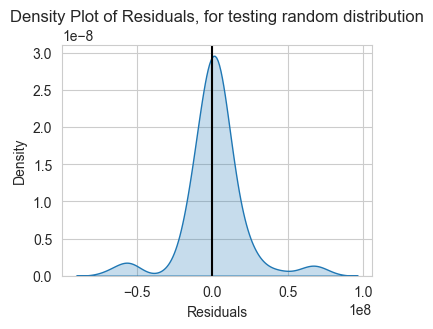

In [149]:
residual_analysis(model.resid)

<h5> since this model passed the raisdual analysis we will procced with prediciton

In [24]:
split_index = int(0.80 * len(clean_POS))
train_data = clean_POS.iloc[:split_index, :]
test_data = clean_POS.iloc[split_index:, :]


In [25]:
model = ARIMA(train_data, order=(0,2,2)).fit()
y_pred = pd.DataFrame(index= test_data.index)
y_pred['Total'] = model.forecast(len(test_data)).values

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


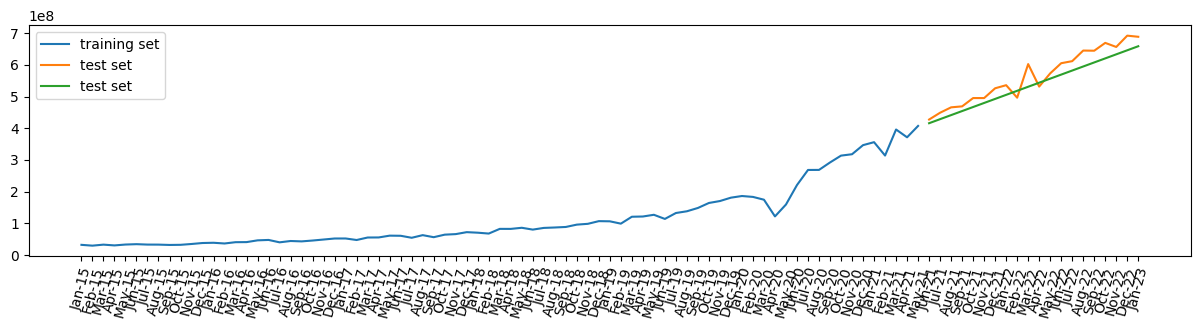

In [26]:
fig = plt.gcf()
fig.set_size_inches(15, 3)
plt.plot(train_data.dropna(), label = 'training set')
plt.plot(test_data.dropna(), label='test set')
plt.plot(y_pred, label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 

In [27]:
KPI(test_data=test_data,y_pred=y_pred)

mape = 0.05206529737946378
mae = 30086577.166925192
mse = 1123490979632695.6
rmse = 33518516.96648728


In [28]:
date_index = pd.date_range(start='2023-02',end= '2025-02', freq='M')

In [29]:
forecast = model.forecast(len(date_index), alpha=0.05)

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [30]:
get_forecast = model.get_forecast(steps=len(date_index),dynamic=True)
confidence_intervals = get_forecast.conf_int()

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [31]:
forecast = pd.DataFrame(forecast.values, index=date_index, columns=['Values'])

In [32]:
CI = pd.DataFrame(confidence_intervals.values, index=date_index,columns=['lower_CI', 'Upper_CI'])

In [33]:
forecast.index = forecast.index.strftime("%b-%y")

In [34]:
CI.index = CI.index.strftime("%b-%y")

Plot diagnostics
It is important to know when we need to go back to the drawing board in model design. In this exercise we will use 4 common plots to decide whether a model is a good fit to some data.


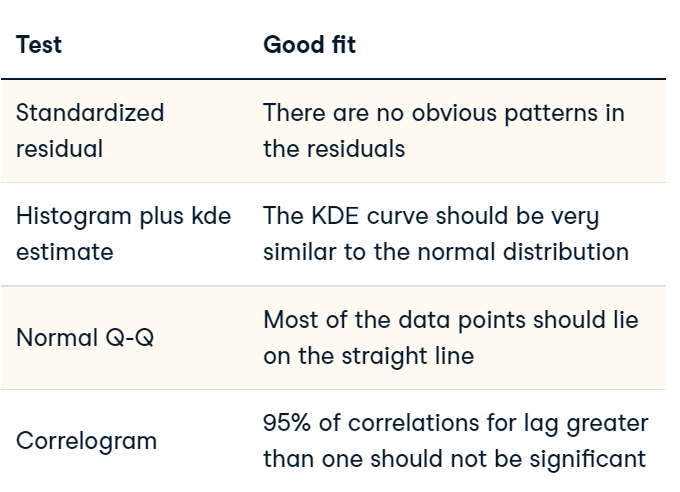

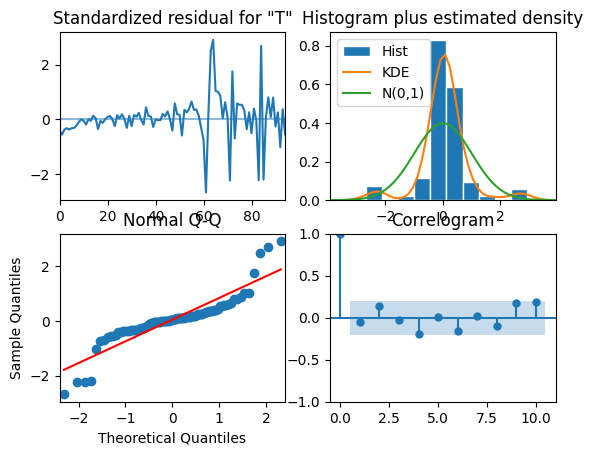

In [35]:
# Create the 4 diagostics plots
model.plot_diagnostics()
plt.show()

In [36]:
forecast_CI = pd.concat([forecast, CI], axis=1)

In [37]:
forecast_CI

,Values,lower_CI,Upper_CI
Feb-23,7.087460e+08,6.599212e+08,7.575707e+08
Mar-23,7.225544e+08,6.661807e+08,7.789281e+08
Apr-23,7.363628e+08,6.719960e+08,8.007297e+08
May-23,7.501713e+08,6.773988e+08,8.229437e+08
Jun-23,7.639797e+08,6.824147e+08,8.455446e+08
Jul-23,7.777881e+08,6.870644e+08,8.685118e+08
Aug-23,7.915965e+08,6.913651e+08,8.918280e+08
Sep-23,8.054050e+08,6.953317e+08,9.154783e+08
Oct-23,8.192134e+08,6.989768e+08,9.394500e+08
Nov-23,8.330218e+08,7.023119e+08,9.637318e+08


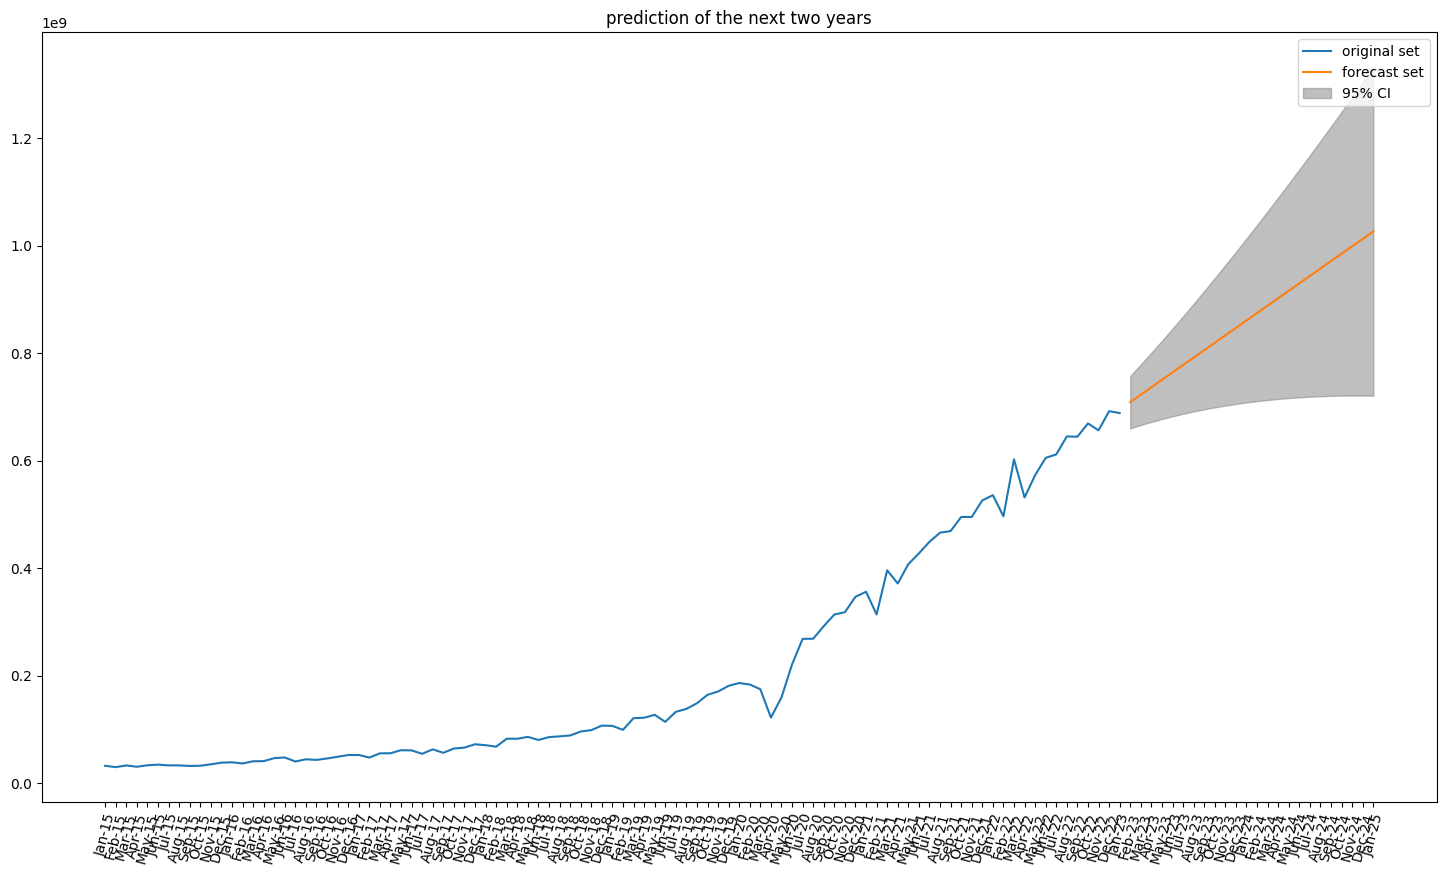

In [38]:
fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.plot(clean_POS, label = 'original set')
plt.plot(forecast , label='forecast set')
plt.fill_between(forecast_CI.index, forecast_CI.lower_CI, forecast_CI.Upper_CI, alpha=0.5, color='gray', label='95% CI')
plt.xticks(rotation=75)
plt.xticks()
plt.legend()
plt.title('prediction of the next two years')
plt.show() 

<h4> To make sure we have the best model, we will try finding another model and compare it with ARIMA(0,2,2)

In [137]:
model2 = ARIMA(clean_POS, order=(2,2,0)).fit()
print(model2.summary())


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   97
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -1742.634
Date:                Thu, 25 May 2023   AIC                           3491.268
Time:                        15:17:56   BIC                           3498.930
Sample:                             0   HQIC                          3494.364
                                 - 97                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0837      0.043    -25.027      0.000      -1.169      -0.999
ar.L2         -0.5118      0.060     -8.590      0.000      -0.629      -0.395
sigma2      5.068e+14   3.26e-17   1.56e+31      0.0

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<h5> since p>|z| < .05, we accept this model <h5>

checking if residuals are zero mean
h0: residuals are zero mean, h1: residuals are not zero mean
since p-value 0.9401 > alpha = 0.05 we accept null hypothesis, residuals are zero mean. 

Anderson-Darling test statistic for checking normality
h0: residuals are normally distributed, h1: residuals are not normally distributed
since p-value 0.758 > alpha = 0.05 we accept null hypothesis, residuals are normally distributed. 

checking for correlation between residuals
h0: residuals are uncorrelated, h1: residuals are correlated
since all p-value < alpha = 0.05 we reject null hypothesis, residuals are correlated. 

checking for ranomnies of residuals
if the are random then we would see a symmetric distribution centered around zero with no significant skewness or kurtosis


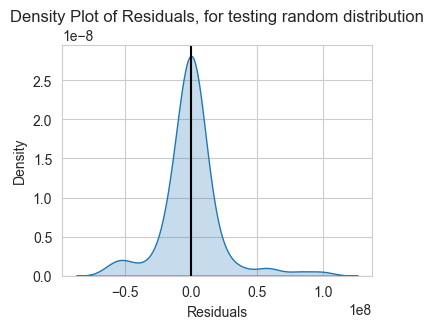

In [165]:
residual_analysis(model2.resid)

<h5> since we found out that residuals are correlated in this model we have to reject the model

<h3> Ponus, trying auto arima function


In [39]:
split_index = int(0.80 * len(clean_POS))
auto_train_data = clean_POS.iloc[:split_index, :]
auto_test_data = clean_POS.iloc[split_index:, :]

In [40]:
auto_model = auto_arima(auto_train_data)

In [41]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   77
Model:               SARIMAX(0, 2, 2)   Log Likelihood               -1358.207
Date:                Thu, 25 May 2023   AIC                           2722.413
Time:                        10:01:57   BIC                           2729.365
Sample:                             0   HQIC                          2725.189
                                 - 77                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1524      0.081    -14.158      0.000      -1.312      -0.993
ma.L2          0.2202      0.064      3.463      0.001       0.096       0.345
sigma2      3.862e+14   4.03e-18   9.59e+31      0.000    3.86e+14    3.86e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               135.11
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              33.40   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.27e+47. Standard errors may be unstable.
"""

since p-value 0.4996 > alpha = 0.05 we accept null hypothesis, residuals are zero mean.
since p-value 0.758 > alpha = 0.05 we accept null hypothesis, residuals are normally distributed.
since all p-value > alpha = 0.05 we accept null hypothesis, residuals are uncorrelated.


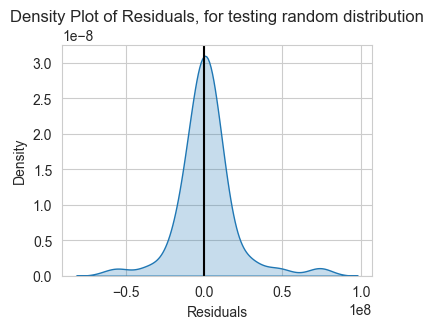

In [139]:
residual_analysis(auto_model.resid())

In [42]:
auto_y_pred = pd.DataFrame(index= auto_test_data.index)
auto_y_pred['Total'] = auto_model.predict(len(auto_test_data)).values

c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [43]:
KPI(y_pred=auto_y_pred, test_data=auto_test_data)

mape = 0.05206529737946378
mae = 30086577.166925192
mse = 1123490979632695.6
rmse = 33518516.96648728


In [44]:
auto_model = auto_arima(clean_POS)
auto_y_pred = pd.DataFrame(index= date_index)
auto_y_pred['Total'] = auto_model.predict(len(date_index)).values


c:\Users\althy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [45]:
auto_y_pred.index = auto_y_pred.index.strftime("%b-%y")

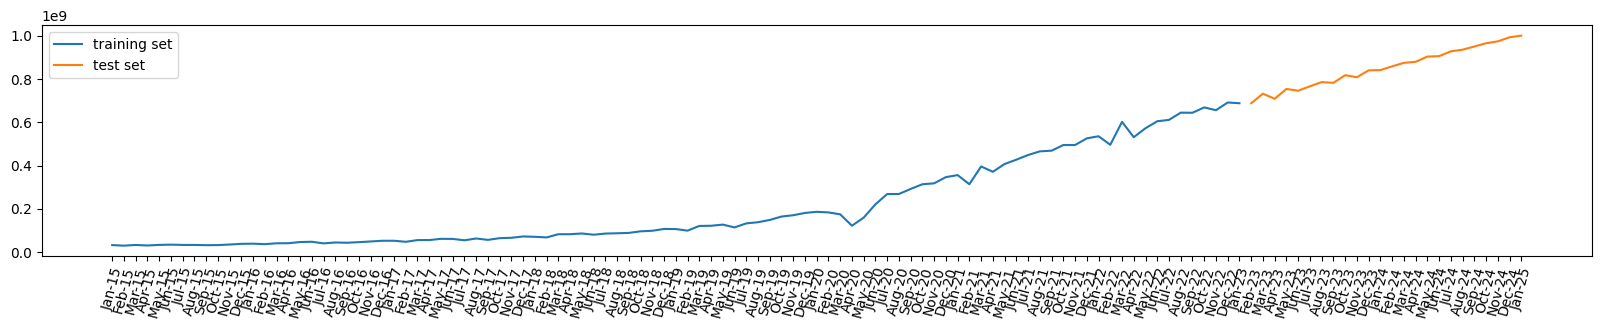

In [46]:
fig = plt.gcf()
fig.set_size_inches(20, 3)
plt.plot(clean_POS, label = 'training set')
plt.plot(auto_y_pred.Total, label='test set')
plt.xticks(rotation=75)
plt.legend()
plt.show() 

<h3> let's compare these two models, my model and the auto arima model

In [140]:
assess_arima(model)

AIC = 3477.8930164967137
BIC = 3485.554647171515


In [142]:
#finding AIC and BIC for auto_arima model
print('AIC =', auto_model.aic())
print('BIC =', auto_model.bic())

AIC = 3465.676176213216
BIC = 3483.5533144544197
